## Lagrangian Neural Network Implementation for modeling the Moab Simulator Data

### Introduction
This notebook implements the Lagrangian Neural Network (LNN) for the Moab device. The goal of this notebook is to explore feasibility of learning the lagrangian from states and actions collected using the Moab simulator data. The hypothesis under consideration are : 1) LNN captures physical behavior of the system from data, and we should observe the model to capture behavioral trends, 2) LNN uses limited data (100 episodes with 250 iteratiosn) a frequent limitation faced in many projects that require a physics based simulator.

If you want to modify for other simulator example, replace the the csv file `moab_sim_100epiMinStates.csv` and add the configuration files in `\conf`. You can use `simulator\moab_simparam.yaml` and `data\moab_5Kepi.yaml` and change the file names in `config.yaml`. `\model` config is not required.

Sources:
  - Original paper on Lagrangian Neural Networks: [Cranmer 2020](https://arxiv.org/abs/2003.04630).
  - It uses the torchdyn library: https://github.com/DiffEqML/torchdyn. 
  - Pytorch and Pytorch Ligtning. Please see the `environment.yml`
  - Please read the `README.md` to run the notebook.



In [1]:
from torchdyn.models import *; from torchdyn.datasets import *
from torchdyn import *
from torch.autograd import grad
from base import BaseModel
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
from hydra.experimental import initialize, compose
from model_loader import available_models
import logging
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.logging import RichHandler
import os

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler()]
)
logger = logging.getLogger("ddm_LNN")
logger.setLevel(logging.INFO)

### Comment or remove overrides if you want to use default configs, but you can use it if you want to experiemnt with a different model or dataset.


In [3]:
initialize(config_path="conf", job_name="LNN_workflow")
cfg = compose(config_name="config", overrides=["data=moab_5Kepi", "model=xgboost"])

C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\hydra\plugins\config_source.py:190: UserWarning: 
Missing @package directive data/moab_5Kepi.yaml in file://C:\Users\sun9k\Documents\PRsReviews\datadrivenmodel\conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\hydra\plugins\config_source.py:190: UserWarning: 
Missing @package directive model/xgboost.yaml in file://C:\Users\sun9k\Documents\PRsReviews\datadrivenmodel\conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\hydra\plugins\config_source.py:190: UserWarning: 
Missing @package directive simulator/moab_simparam.yaml in file://C:\Users\sun9k\Documents\PRsReviews\datadrivenmodel\conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directiv

In [4]:
cfg["data"]

{'path': 'csv_data/moab_sim_5KepiPosVelMinStates.csv', 'full_or_relative': 'relative', 'inputs': 'state', 'outputs': 'state', 'augmented_cols': ['action_input_roll', 'action_input_pitch'], 'iteration_order': -1, 'episode_col': 'episode', 'iteration_col': 'iteration', 'max_rows': 230000, 'scale_data': True, 'diff_state': True}

In [5]:
cfg["model"]

{'name': 'xgboost', 'build_params': {'model_type': 'xgboost', 'halt_model': False, 'num_trees': 50, 'objective': 'reg:squarederror', 'step_size': 0.3, 'device': 'cpu', 'batch_size': 128, 'gamma': 0, 'scale_data': True, 'max_bin': 256}, 'saver': {'filename': 'models/boost/moab/xgboost_model'}, 'sweep': {'run': False, 'search_algorithm': 'bayesian', 'num_trials': 3, 'scoring_func': 'r2'}}

In [6]:
dir_path = os.path.join("models")

In [7]:
# Extract features from yaml file
input_cols = cfg['data']['inputs']
output_cols = cfg['data']['outputs']
augmented_cols = cfg['data']['augmented_cols']
dataset_path = cfg['data']['path']
iteration_order = cfg['data']['iteration_order']
episode_col = cfg['data']['episode_col']
iteration_col = cfg['data']['iteration_col']
max_rows = cfg['data']['max_rows']
delta_state = cfg["data"]["diff_state"]
## For loading and predicting directly
save_path = cfg["model"]["saver"]["filename"]
if cfg["data"]["full_or_relative"] == "relative":
    save_path = os.path.join(dir_path, save_path)
model_name = cfg["model"]["name"]
states = cfg["simulator"]["states"]
actions = cfg["simulator"]["actions"]
configs = cfg["simulator"]["configs"]
policy = cfg["simulator"]["policy"]
logflag = cfg["simulator"]["logging"]
scale_data = cfg["model"]["build_params"]["scale_data"]

In [8]:
print("DATA STRUCTURE SELECTED:")
print(" - input_cols:", input_cols)
print(" - augmented_cols:", augmented_cols)
print(" - output_cols:", output_cols)

### Get Organized data in the X,y format as used in DDM model and train XGBoost Benchmark

In [9]:
def order_data(config=cfg):

    logger.info(f'Model type: {available_models[config["model"]["name"]]}')
    Model = available_models[config["model"]["name"]]
    model = Model()
    logger.info(f"Building model with parameters: {config}")
    model.build_model(
        **config["model"]["build_params"]
    )
    logger.info(f"Loading data from {dataset_path}")
    global X, y
    X, y = model.load_csv(
        input_cols=input_cols,
        output_cols=output_cols,
        augm_cols=list(augmented_cols),
        dataset_path=dataset_path,
        iteration_order=iteration_order,
        episode_col=episode_col,
        iteration_col=iteration_col,
        max_rows=max_rows,
        diff_state=delta_state,
    )

    return model

In [10]:
xgmodel = order_data(cfg)

### Using Above Training Data for TorchDyn Class

`ydel` is the diff_states, but is already converted using the `diff_state` argument.

In [11]:
X.shape

(192027, 10)

In [12]:
y.shape

(192027, 8)

In [13]:
model = BaseModel()

In [14]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# A=torch.Tensor(2**15, 2).uniform_(-1, 1).to(device) # random data test

In [15]:
ydel = y # Note that y is change in states st+1-st , if diff_state config was True in DDM configs.
Xs, ys = model.scalar(X,y)
Xst = torch.from_numpy(Xs.astype(np.float32))
yst = torch.from_numpy(ys.astype(np.float32))

### Verifying Diff States
#### Verifying that difference in previous state and current state is correctly arranged. In the logging, there are couple of ways the states, actions and next states are arranged. It is easy to make a mistake. So, delibrate inspection can be useful here.

$x_{st} = y_{st-1} + x_{s_{t_1}}^{j_1,j_8}$

In [16]:
X[11,:] # 11 is a random row used for inspection

array([  0.58174837,   0.79372551,  -0.07364562,   0.03293362,
       -10.        ,  -7.11461007,   0.04523724,  -0.19350497,
         0.58174837,   0.79372551])

In [17]:
ydel[10,:]+X[10,:len(states)] # number of states =8

array([  0.58174837,   0.79372551,  -0.07364562,   0.03293362,
       -10.        ,  -7.11461007,   0.04523724,  -0.19350497])

#### Inspect scaled data

In [18]:
Xs[11,:] # scaled input

array([ 1.00376404,  1.37021869, -1.16065784,  0.51424333, -1.17504338,
       -0.83367583,  0.09025889, -0.3802492 ,  1.00376404,  1.37021869])

In [19]:
ys[10,:]+Xs[10,:len(states)] # effect of scaled output

array([ 0.37930796,  1.24013251, -1.64294608,  0.88313887, -0.45648427,
       -0.33543529,  0.0581093 , -0.31172961])

### Inspect scaled diff states data

In [20]:
Xst[1,:]-Xst[0,:] # verify that a_t is not same as a_t recorded last as part of s_t i.e. column 6,7 != column 0,1

tensor([-2.2774,  1.2045, -0.4401,  3.1311,  0.9395,  0.0000, -2.2410,  2.7090,
        -2.2774,  1.2045])

In [21]:
yst[0,:] # not exactly same

tensor([-1.6123e+00,  8.5438e-01, -6.0367e-01,  4.3832e+00,  5.7190e-01,
        -2.2681e-03, -3.5268e+00,  4.2536e+00])

In [22]:
train_size = 180000

### Arrange split 

TODO: capture input shape and output shape, and then use output_shape to slice instead of hard-coding

In [23]:
Xtrain = Xst[:train_size,:len(states)] # For non-Moab cases: torch.cat((Xst[:20000,:4],yst[:20000,:2]-Xst[:20000,-2:], Xst[:20000,2:4]),1)
Xtest  = Xst[train_size:,:len(states)]  # For non-Moab cases: torch.cat((Xst[20000:,:4],yst[20000:,:2]-Xst[20000:,-2:],Xst[20000:,2:4]),1)
ytrain = yst[:train_size,:]
ytest = yst[train_size:,:]

In [24]:
# Training dataset as part of dataloader for Pytorch Lightning
# m, k, b = 1, 1, 1 # Not used here but can be used as scaling parameters for pos and vel states
train = data.TensorDataset(Xtrain, ytrain) #data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=128, shuffle=False)
test = data.TensorDataset(Xtest, ytest) #data.TensorDataset(X, Xdd)
testloader = data.DataLoader(test, batch_size=128, shuffle=False)

predict = data.TensorDataset(Xtest, ytest) #data.TensorDataset(X, Xdd)
predict_loader = data.DataLoader(predict, batch_size=128, shuffle=False)

### LNN modeling
Here, L and f are the lagrangian neural network and f is the forcing function. Action is added to fLNN to be used in the forcing function directly.

In [25]:
class fLNN(nn.Module):
    def __init__(self, L, f, u):
        super().__init__()
        self.L, self.f, self.u = L, f, u
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 # Split in position and velocity states, 
            qqd = x.requires_grad_(True) # m x 8
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ; # m x 8
            DL_q, DL_qd = J[:,:n], J[:,n:] #J[:,:n], J[:,n:] mx4, mx4
            DDL_qd = []
            for i in range(n): # Replace range from n to full dimension. Previously used range(n):
                J_qd_i = DL_qd[:,i][:,None] # m x 1
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None] # m x 4
                DDL_qd.append(H_i) #m x 8 x 2 2 times
            DDL_qd = torch.cat(DDL_qd, 2) # m x 8 x 4
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]### m x 4 x 4, m x4 x 4
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # m x 4 x 4, m x 4 -> m x 4
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T - self.f(self.u[:len(qqd),:]))#self.f(qqd))#[:,n:]) mx4x4,mx 4

        return torch.cat([qqd[:,self.n:], qdd], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

### Learner is the function used for training, testing and predictions. 
Optimizer and learning rate can be changed here, or passed externally. Functions for test and predict are added to track outputs of prediction later

In [26]:
import pytorch_lightning as pl
# from pytorch_lightning import loggers as pl_loggers
# tb_logger = pl_loggers.TensorBoardLogger('logs/')

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.defunc(0, x)

    def loss(self, y_hat, y):
        return ((y - y_hat)**2).mean()#((y - y_hat[:,1])**2).mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
#         print(loss.detach())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss' : loss, 'y_pred' : y_hat, 'y_true' : y}#{'loss': loss}
    
    def test_step(self, batch, batch_idx):
        # Gets "x" and "y" tensors for current batch
        x, y = batch
        # OK to use output of forward for test (as per best practices PL)
        y_test = self.forward(x)
        # Calculate loss for the current batch
        loss = self.loss(y_test, y)
        self.log('y_test', y)

        return  {'test_loss' : loss }

    def predict(self, batch, batch_idx: int , dataloader_idx: int = None):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
        return {'loss' : loss, 'y_pred' : y_hat, 'y_true' : y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader
    
    
    def test_dataloader(self):
        return testloader

### Network Architecture for Lagrangian and forcing function
The lagrangian network L takes 4 inputs, two ball positions for x and y coordinates, and two ball velocities for xdot and ydot, representing state at time t (s_t). L has 4 outputs for the corresponding 4 states at time t+1 (s_t+1). Similarly, forcing function has 2 inputs for the two actions `roll` and `pitch`, outputs are two accelerations of the forces. Here, the forces are kept independent of states, as they are acting as external input. In some cases, force can be a function of states also. But, ball states usually do not affect the force, in case of Moab.

In [27]:
hdim = 128
inp_dim = 8
out_dim = 8
num_actions = 2
L = nn.Sequential(
            nn.Linear(inp_dim, hdim),  ## Input is 8
            nn.Softplus(),
            nn.Linear(hdim, hdim),
            nn.Softplus(),
            nn.Linear(hdim, out_dim)).to(device) ## Output is 8

# Using forces independent of dynamics q and qd, all interaction is handled in fLLN.
f = nn.Sequential(
            nn.Linear(num_actions, hdim), ## Input is 2 for 2 actions
            nn.Softplus(),
            nn.Linear(hdim, 4)).to(device) ## Output is 4 accelerations
netf = fLNN(L, f, Xst[:train_size,-2:]) # last two are actions
modelf = NeuralDE(func=netf, solver='dopri5').to(device)

### Uncomment and run this cell to Train Again

In [28]:
# learn = Learner(modelf)
# trainer = pl.Trainer(max_epochs=5, log_every_n_steps=5) #, logger=tb_logger)#0)
# trainer.fit(learn)
# trainer.save_checkpoint("modelDelState.ckpt")

### Re-load from checkpoint - Trained Network

In [29]:
ckpt = torch.load("modelDelState.ckpt")
nrows = 250
batchsize =250

In [30]:
# Use checkpointed learned network for 1st prediction
def batch_predict(i=0):
    test1 = data.TensorDataset(Xtest[i:i+nrows,:], ytest[i:i+nrows,:]) #data.TensorDataset(X, Xdd)
    predict_loaders1 = data.DataLoader(test1, batch_size=nrows, shuffle=False)
    netf = fLNN(L, f, Xtest[i:i+nrows,:2]) # Send Action from forcing function
    modelf = NeuralDE(func=netf, solver='dopri5').to(device)
    learn1 = Learner(modelf)
    learn1.load_state_dict(ckpt['state_dict'])
    learn1.eval()

    trainer1 = pl.Trainer()
    ypred1=trainer1.predict(learn1, predict_loaders1)
# yout1 = np.concatenate((np.array(yst[200000:200000+i,:2]),ypred1[0]['y_pred']),axis=1)
    y_out=model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    y_out1 = X[train_size+i,:len(states)]+model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    return y_out,y_out1, ypred1

### Test and Predict
#### LNN Single Step Prediction

In [31]:
nrows = 50
y_out, y_out1, y_pred = batch_predict(i=0)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

### Check visually how states are predicted w.r.t sim data (Red = Sim Data, Blue= Model prediction)

### Note: The visualization can be personalized based on user preferences. You may install your favorite visualization tools e.g. Plotly, Bokeh, Seaborn, or others.

#### Roll Action Delta

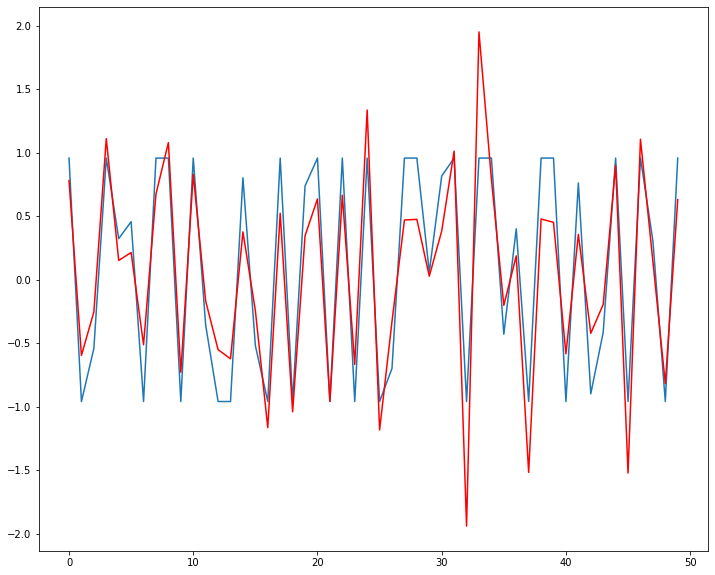

In [32]:
from matplotlib import pyplot as plt
plt.plot(y_out[:nrows,0])
plt.plot(ydel[train_size:train_size+nrows,0],'r')

#### Pitch Action Delta

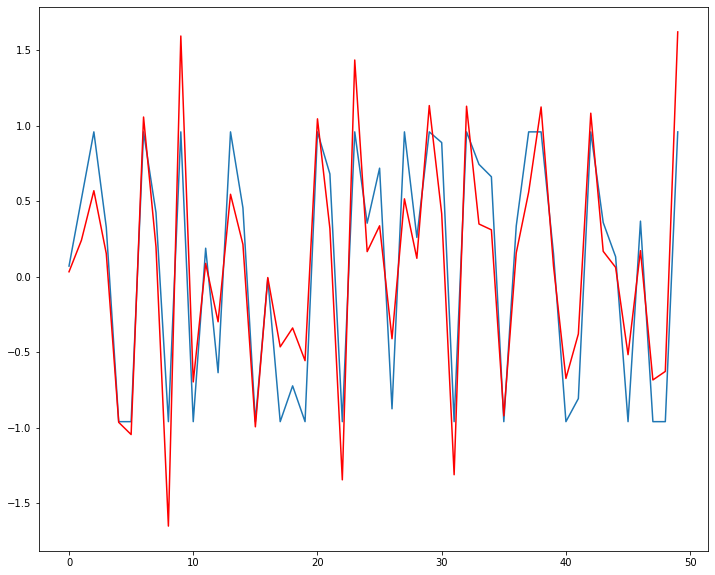

In [33]:
plt.plot(y_out[:nrows,1])
plt.plot(ydel[train_size:train_size+nrows,1],'r')

#### Ball X positiondelta  over 150 time-steps

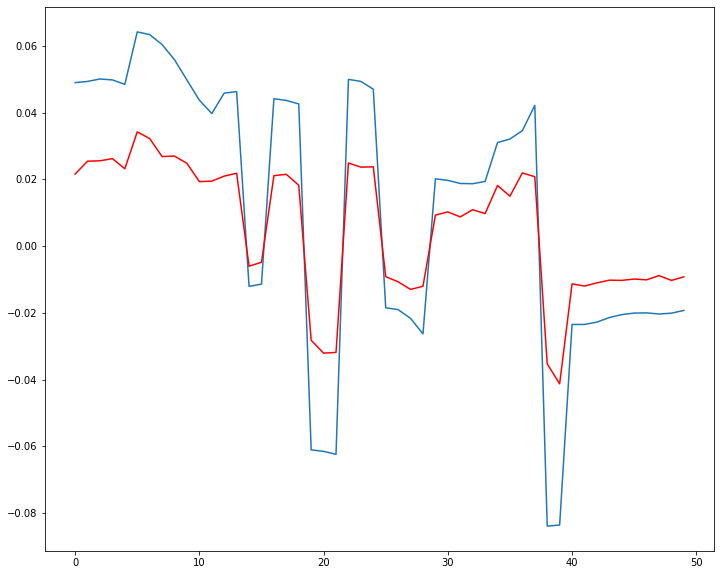

In [34]:
plt.plot(y_out[:nrows,2])
plt.plot(ydel[train_size:train_size+nrows,2],'r')

#### Ball Y position delta over 150 time-steps

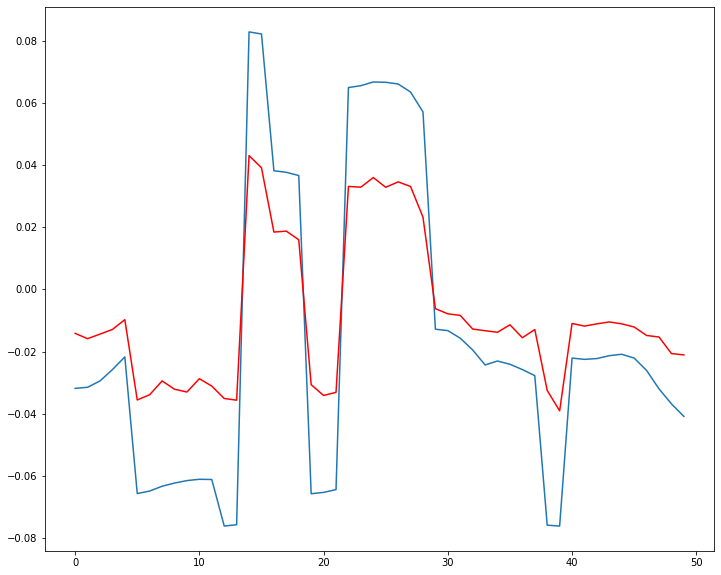

In [35]:
plt.plot(y_out[:,3])
plt.plot(ydel[train_size:train_size+nrows,3],'r')

#### Ball X velocity delta 

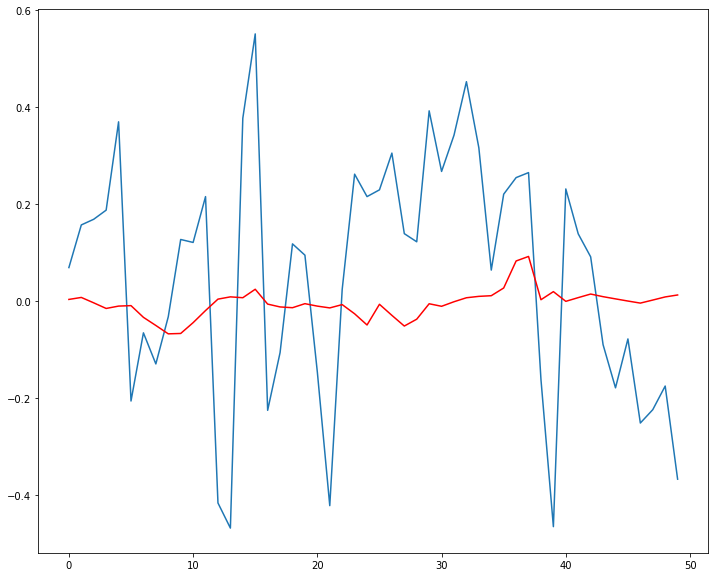

In [36]:
plt.plot(y_out[:nrows,6])
plt.plot(ydel[train_size:train_size+nrows,6],'r')

#### Ball Y velocity delta

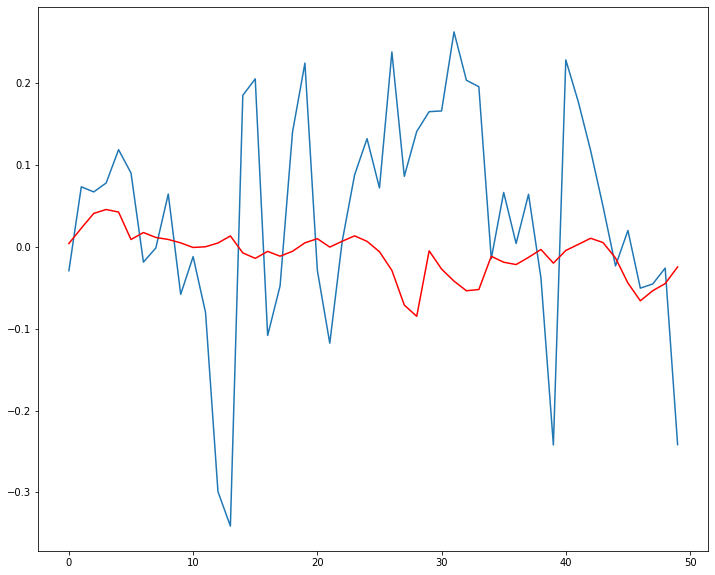

In [37]:
plt.plot(y_out[:,7])
plt.plot(ydel[train_size:train_size+nrows,7],'r')

#### Ball X position

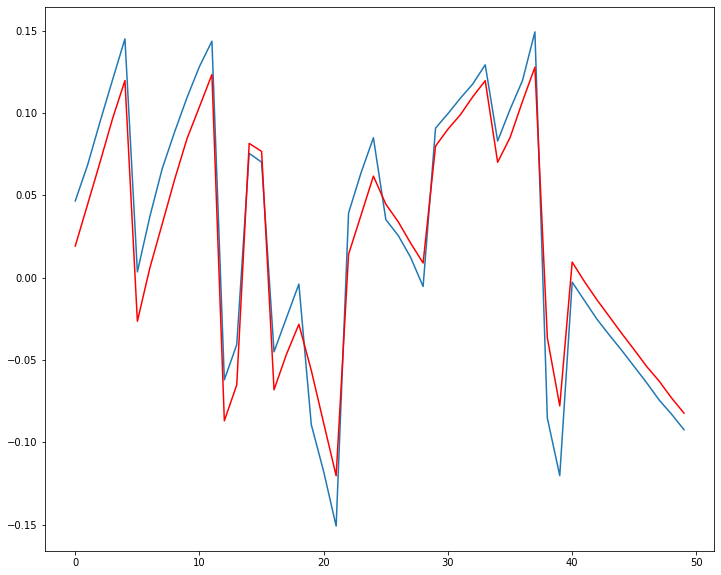

In [38]:
plt.plot(X[train_size:train_size+nrows,2]+y_out[0:nrows,2])
plt.plot(X[train_size:train_size+nrows,2]+y[train_size:train_size+nrows,2],'r')

#### Ball Y position

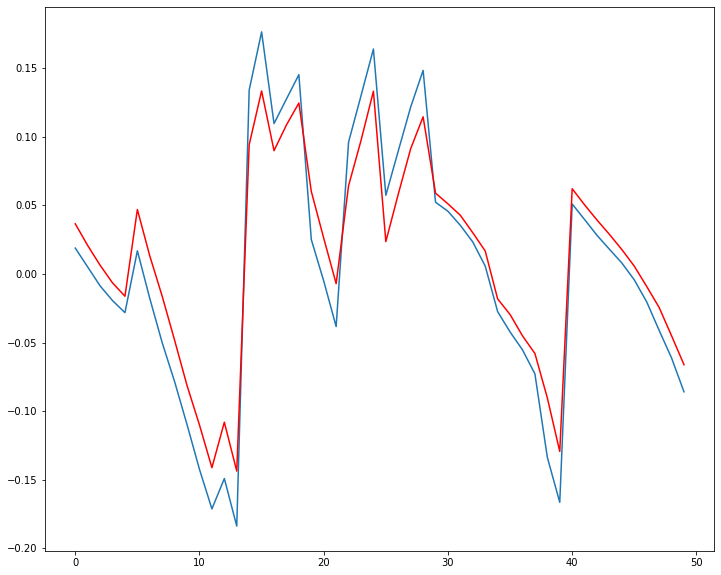

In [39]:
plt.plot(X[train_size:train_size+nrows,3]+y_out[0:nrows,3])
plt.plot(X[train_size:train_size+nrows,3]+y[train_size:train_size+nrows,3],'r')

#### Ball X velocity over 50 time-steps

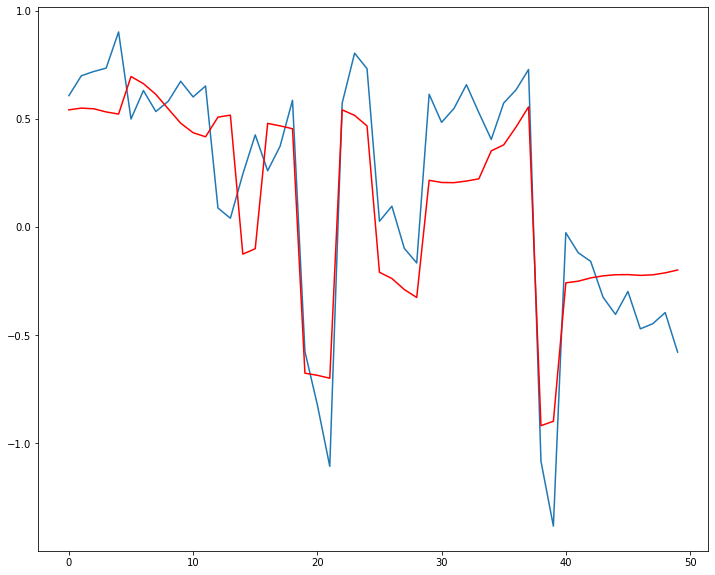

In [40]:
plt.plot(X[train_size:train_size+nrows,6]+y_out[:nrows,6])
plt.plot(X[train_size:train_size+nrows,6]+y[train_size:train_size+nrows,6],'r')

#### Ball Y velocity over 50 time-steps

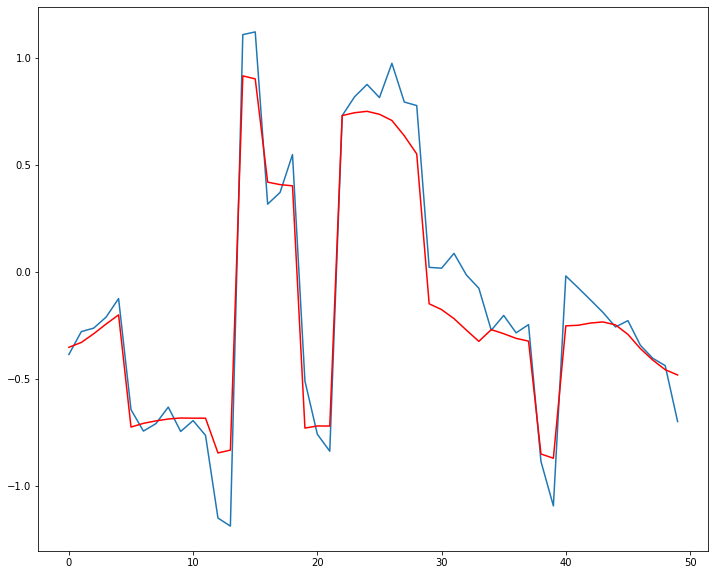

In [41]:
plt.plot(X[train_size:train_size+nrows,7]+y_out[:nrows,7])
plt.plot(X[train_size:train_size+nrows,7]+y[train_size:train_size+nrows,7],'r')

In [42]:
LNN_singlestep=np.square(X[train_size:train_size+nrows,:len(states)]+y_out[:nrows,:len(states)]-y[train_size:train_size+nrows,:]).sum(axis=0)/nrows

In [43]:
LNN_singlestep

array([5.11762235e-01, 5.34141229e-01, 5.13389636e-03, 5.28653956e-03,
       3.92825285e+02, 4.32703018e+02, 3.51779549e-01, 3.91466293e-01])

### Error Propagation

### Predict LNN for entire episode sequentially

#### First pass -- similar to episode start in brain/RL training

In [44]:
def iterative_predict(s_t,a_t):
    test1 = data.TensorDataset(s_t, s_t) #data.TensorDataset(X, Xdd)
    predict_loaders1 = data.DataLoader(test1, batch_size=1, shuffle=False)
    netf = fLNN(L, f, a_t) # Send Action from forcing function
    modelf = NeuralDE(func=netf, solver='dopri5').to(device)
    learn1 = Learner(modelf)
    learn1.load_state_dict(ckpt['state_dict'])
    learn1.eval()
    trainer1 = pl.Trainer()
    ypred1=trainer1.predict(learn1, predict_loaders1)
    y_out1 = model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    return y_out1, ypred1

In [45]:
i=0
np.array(yst[train_size:train_size+i,:2]).shape

(0, 2)

In [46]:
y_out1,ypred1 = iterative_predict(Xtest[i:i+1,:],Xtest[i:i+1,:2])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

In [47]:
ypred1[0]['y_pred']

array([[ 1.1743684 ,  0.08833291,  1.0618216 , -0.6987942 , -0.45980477,
        -0.9112936 ,  0.21740237, -0.0897542 ]], dtype=float32)

In [48]:
ypred1[0]['y_true']

array([[-0.75058395, -1.3902543 , -0.04327359,  0.7929423 ,  1.1743684 ,
         0.08833291,  1.0618216 , -0.6987942 ]], dtype=float32)

In [49]:
y_out1

array([[  0.95871174,   0.07050006,   0.04903645,  -0.03182812,
         -6.4262967 , -12.704946  ,   0.06962212,  -0.0292525 ]],
      dtype=float32)

In [50]:
y[train_size+1,:]

array([-0.59560081,  0.24169961,  0.02548413, -0.01584328,  4.35900968,
        4.62889762,  0.00804919,  0.02264601])

In [51]:
X[:10,9]

array([ 0.16347921,  0.85921935, -0.46637819,  0.07951492,  0.49635493,
        0.1059989 , -0.65290156,  0.43454274, -0.10611042, -0.89712592])

#### All following passes: similar to episode step in brain/RL training

In [52]:
nrows=50
o_list = [ypred1[0]['y_pred']]
y_list = [ypred1[0]['y_true']]
yout_list=[y_out1]#.reshape(1,6)]
yinp = model.yscalar.transform(y_out1)
for i in range(1,nrows):
    y_out1, ypred1 = iterative_predict(torch.from_numpy(yinp.astype(np.float32)),Xtest[i:i+1,:2])
    y_out1 = y_out1+model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    yinp = model.yscalar.transform(y_out1)
    o_list.append(ypred1[0]['y_pred'])
    y_list.append(ypred1[0]['y_true'])
    yout_list.append(y_out1)#.reshape(1,6))
    if (abs(y_out1[0][2])>0.1125) or (abs(y_out1[0][3])>0.1125): # Radius of plate is 0.1125m so ball falls off.
        y_out1,y_pred1 = iterative_predict(Xtest[i:i+1,:],Xtest[i:i+1,:2])
        yinp = model.yscalar.transform(y_out1+X[train_size+i,:len(states)])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\sun9k\Miniconda3\envs\ddm\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Predicting: 0it [00:00, ?it/s]

In [53]:
yinp

array([[ 0.62236199,  0.35108306, -1.99424903, -1.88472812,  0.25528889,
        -0.14702805, -1.78904789, -2.15549448]])

In [54]:
ypred1[0]['y_pred']

array([[-0.31186593, -0.88054526, -1.2220666 , -1.3498363 , -0.41532266,
        -1.2852516 , -1.6688359 , -0.89570963]], dtype=float32)

In [55]:
ol=np.concatenate(o_list,axis=0)
yl = np.concatenate(y_list,axis=0)
yo = np.concatenate(yout_list,axis=0)

### Actual and predicted moab states at time t+1
### Prediction using previous inputs of model-entire trajectory prediction

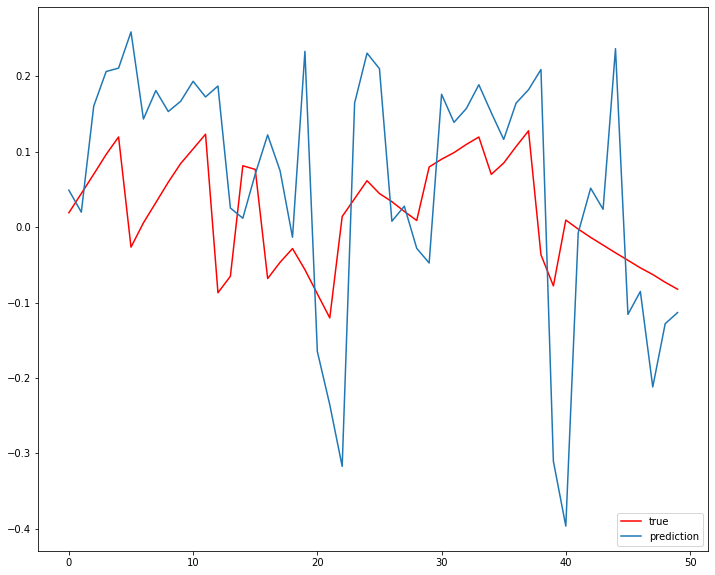

In [56]:
plt.plot(X[train_size:train_size+nrows,2]+y[train_size:train_size+nrows,2],'r',label='true')
plt.plot(yo[:nrows,2],label='prediction')
plt.legend(loc="lower right")

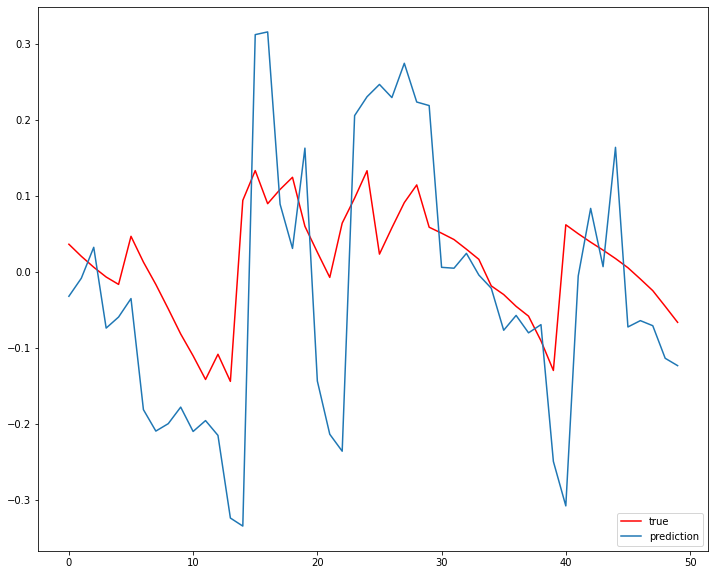

In [57]:
plt.plot(X[train_size:train_size+nrows,3]+y[train_size:train_size+nrows,3],'r',label='true')
plt.plot(yo[:nrows,3],label='prediction')
plt.legend(loc="lower right")
# plt.plot((X[train_size:train_size+50,7]==0).astype(np.float32)*0.1,'.k',label='episode')

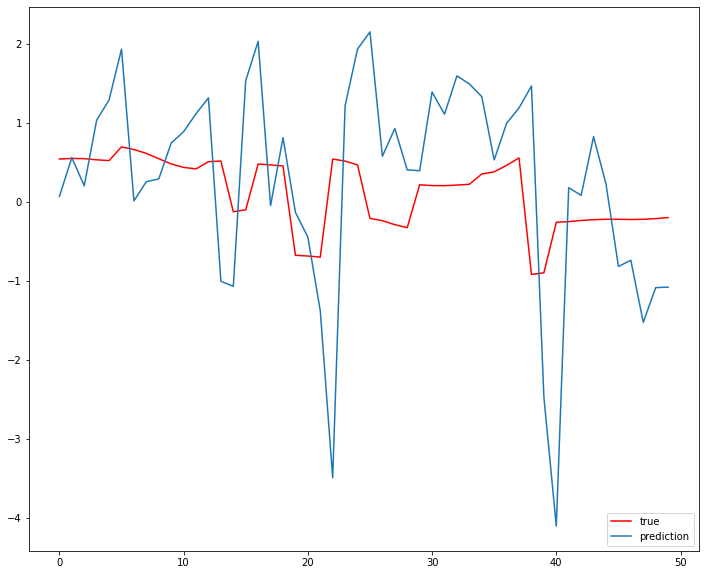

In [58]:
plt.plot(X[train_size:train_size+nrows,6]+y[train_size:train_size+nrows,6],'r',label='true')
plt.plot(yo[:nrows,6],label='prediction')
plt.legend(loc="lower right")

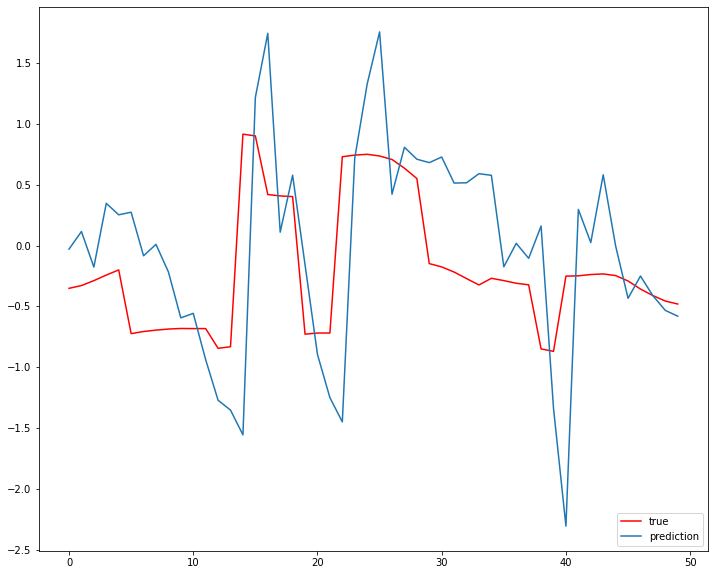

In [59]:
plt.plot(X[train_size:train_size+nrows,7]+y[train_size:train_size+nrows,7],'r',label='true')
plt.plot(yo[:nrows,7],label='prediction')
plt.legend(loc="lower right")

In [60]:
yo.shape

(50, 8)

In [61]:
LNN_episode=np.square(X[train_size:train_size+nrows,:8]+y[train_size:train_size+nrows,:]-yo[:nrows,:]).sum(axis=0)/nrows

In [62]:
LNN_episode

array([2.46148927e+00, 2.62214467e+00, 2.08686747e-02, 2.00993808e-02,
       7.11222062e+02, 9.68985102e+02, 1.54581336e+00, 5.88051479e-01])

In [63]:
LNN_singlestep

array([5.11762235e-01, 5.34141229e-01, 5.13389636e-03, 5.28653956e-03,
       3.92825285e+02, 4.32703018e+02, 3.51779549e-01, 3.91466293e-01])